# Stochastic partial differiential equations - Practical

Objective: Perform conditional and unconditional simulations of a random field $Z$ defined as a solution of the SPDE :

$(\mathcal{\kappa}^{2} - \Delta)^{\alpha}Z = \mathcal{W}$ 

where $\mathcal{\kappa} \gt 0$ and $\mathcal{W}$ is a spatial white noise.

Numerically, we work on a discretized space, here a 2D grid. We try to simulate the field in a discrete set of points:

{$Z(i,j) : (i,j)$ grid cell}

- Load the required modules

In [334]:
import logging
from typing import Optional, Union, Tuple, Callable
import numpy as np
import numpy.typing as npt
import scipy
import sksparse 
from scipy.special import kv
from scipy.spatial import distance_matrix
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import LinearOperator, gmres, splu
from sksparse.cholmod import cholesky, Factor
from sklearn.gaussian_process.kernels import Matern as skMatern
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from nested_grid_plotter import NestedGridPlotter, multi_imshow

- Type hints definition for numpy arrays

In [2]:
NDArrayFloat = npt.NDArray[np.float64]
NDArrayInt = npt.NDArray[np.int64]

- Set-up logging level

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [5]:
logging.info(f"numpy version = {np.__version__}")
logging.info(f"scipy version = {scipy.__version__}")
logging.info(f"sksparse version = {sksparse.__version__}")
logging.info(f"matplotlib version = {mpl.__version__}")

INFO:root:numpy version = 1.23.5
INFO:root:scipy version = 1.9.1
INFO:root:sksparse version = 0.4.8
INFO:root:matplotlib version = 3.5.1


- Set a random number generator to obtain reproducible results. Here , we generate a seed from a cool sentence (Note: this is an incremental generator)


In [6]:
rng = np.random.default_rng(np.abs(hash("mike is the best")))

## EDP discretization

- Add some blabla about the grid discretization

- Define a function to convert mesh indices $(i,j)$ to node numbers

In [7]:
def indices_to_node_number(ix: int, nx: int, iy: int, ) -> int:
    """
    Convert indices (i,j) to a node number.

    Parameters
    ----------
    ix : int
        Index along x.
    nx : int
        Number of meshes along y.
    iy : int
        Index along y.
    

    Returns
    -------
    int
        The node number.

    """
    return ix + nx * iy

# Example
indices_to_node_number(10, 4, 5)

30

- Define the laplacian matrix

In [8]:
def get_laplacian_matrix(
    nx: int, ny: int, dx: float, dy: float, kappa: Union[NDArrayFloat, float]
) -> csc_matrix:
    """
    Return a sparse matrix of the discretization of the Laplacian.

    Parameters
    ----------
    nx : int
        Number of meshes along x.
    ny : int
        Number of meshes along y.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    kappa : float
        Range (length scale).

    Returns
    -------
    csc_matrix
        Sparse matrix with dimension (nx * ny)x(nx * ny) representing the  discretized
        laplacian.

    """
    n_nodes = nx * ny
    if np.isscalar(kappa):
        _kappa = np.full(n_nodes, fill_value=kappa)
    else:
        _kappa = np.array(kappa)
    # construct an empty sparse matrix (lil_format because it supports indexing and
    # slicing).
    lap = lil_matrix((n_nodes, n_nodes), dtype=np.float64)

    # Looping on all nodes and considering neighboors
    for i in range(nx):
        for j in range(ny):
            node_index = indices_to_node_number(i, nx, j)
            lap[node_index, node_index] += _kappa[node_index]**2 + 2 / dx**2 + 2 / dy**2
            if i > 0:
                neighbor_index = indices_to_node_number(i - 1, nx, j)
                lap[node_index, neighbor_index] += -1.0 / dx**2
            if i < nx - 1:
                neighbor_index = indices_to_node_number(i + 1, nx, j)
                lap[node_index, neighbor_index] += -1.0 / dx**2
            if j > 0:
                neighbor_index = indices_to_node_number(i, nx, j - 1)
                lap[node_index, neighbor_index] += -1.0 / dy**2
            if j < ny - 1:
                neighbor_index = indices_to_node_number(i, nx, j + 1)
                lap[node_index, neighbor_index] += -1.0 / dy**2

    # Convert from lil to csr matrix for more efficient calculation
    return lap.tocsc()

- Make a test on a small grid (10, 10) and plot the matrix (we expect a three bands matrix)

Text(0.5, 1.0, 'Laplacian matrix')

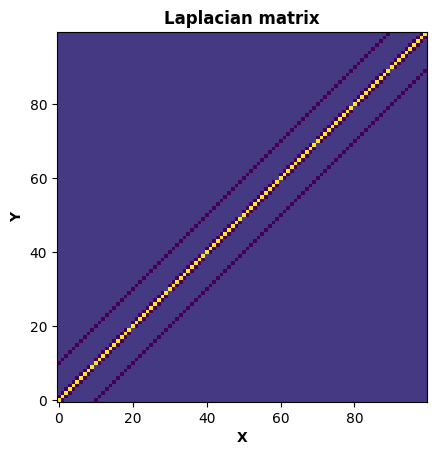

In [9]:
# 1) Test the get laplacian function
kappa = np.ones([10 * 10])
lap_mat = get_laplacian_matrix(10, 10, 1, 1, kappa)

# Plot the sparse matrix -> 3 non null bands
plt.imshow(lap_mat.todense(), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Laplacian matrix", fontweight="bold")

## Unconditional simulation

We obtain an unconditional simulation of the vector $Z$ by solving the linear system introduced above for a vector $\mathcal{W}$ whose components are independent Gaussians of variance $\dfrac{1}{dxdy}$ .

In [10]:
def simu_nc(
    lap_mat: csc_matrix,
    dx: float,
    dy: float,
    kappa: float,
    alpha: float,
    spatial_dim: int,
    rng: np.random.Generator,
    preconditioner: Optional[LinearOperator] = None,
) -> NDArrayFloat:
    """
    Return the gaussian solution of the discretized EDPS (gaussian vector).

    Note
    ----
    This is valid for alpha = 1 only.

    Parameters
    ----------
    lap_mat : csc_matrix
        The laplacian matrix.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    rng: np.random.Generator
        Random number generator.
    preconditioner: Optional[LinearOperator]
        Preconditioner for the sparse matrix.
        
    Returns
    -------
    NDArrayFloat
        The simulation.

    """
    # Fonctions R utiles: ncol, rnorm, solve

    # white noise with size nx * ny -> scale is the standard deviation
    w = rng.normal(loc=0, scale=np.sqrt(1 / (dx * dy)), size=lap_mat.shape[0])

    # Use a LU preconditioner to get faster computation
    z, info = gmres(lap_mat, w, M=preconditioner, atol=1e10)

    nu = 2 * alpha - spatial_dim / 2
    # La variance n'est pas exactement 1. On divise par l'écart type de la variance.
    # tau = kappa * np.sqrt((4 * np.pi * np.math.gamma(2) / np.math.gamma(1)))
    tau = (kappa) * np.sqrt(4 * np.pi * np.math.gamma(2 * alpha) / np.math.gamma(nu))

    return z * tau

- Note that for faster solving, one can provide a LU preconditioner of the sparse laplacian matrix.

In [11]:
def get_preconditioner(mat: csc_matrix) -> LinearOperator:
    """Get the preconditioner for the given matrix."""
    op = splu(mat)

    def super_lu(x):
        return op.solve(x)

    return LinearOperator(mat.shape, super_lu)


- Define some simulation parameters

In [12]:
# We define nx and ny different to check the indexing
nx = 100
ny = 110  # grid size definition (meshes)
n_nodes = nx * ny  # number of meshes
dx = dy = 1 / nx  # mesh size
kappa = 30  # inverse of length scale
alpha = 1  # regularity parameter
spatial_dim = 2  # we work in 2d (parameter d)

- Build the laplacian matrix and its LU preconditioner (to solve the Ax  b system faster)

In [13]:
simu_lap_mat = get_laplacian_matrix(nx, ny, dx, dy, kappa)
preconditioner = get_preconditioner(simu_lap_mat)

- Non conditional simulation with a given seed for the white noise. Plot the results

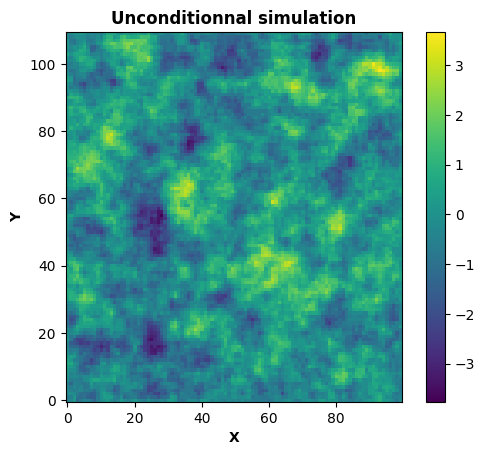

In [14]:
z = simu_nc(simu_lap_mat, dx, dy, kappa, alpha, spatial_dim, rng, preconditioner)
# Display the simulated field
plt.imshow(z.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Unconditionnal simulation", fontweight="bold")
plt.colorbar()

### Comparision with a Matérn field

- Define a general function for a Matérn field

This model is given by the following correlation function [Rasmussen2003]:

$\rho(r) = \frac{2^{1-\nu}}{\Gamma\left(\nu\right)} \cdot \left(\sqrt{\nu}\cdot r \cdot \mathcal{\Kappa} \right)^{\nu} \cdot \mathrm{K}_{\nu}\left(\sqrt{\nu}\cdot r \cdot \mathcal{\Kappa} \right)$

Where $\Gamma$ is the gamma function and $\mathrm{K}_{\nu}$ is the modified Bessel function of the second kind.

- Define the parameters for the Matérn field

In [16]:
field_dimension = 2  # field dimension
alpha = 1  # differential operator degree

# Variographic parameters
# number of points selected in a simulation for the calculation of the
# experimental variogram
n0 = int(0.2 * (nx * ny))
# Spacestep between points
lag = 0.05
nbpts = 10  # number of points in the variogram

- Define a function to get the experimental variogram from a field

In [17]:
def get_exp_var(
    z: NDArrayFloat,
    n0: int,
    lag: float,
    nbpts: int,
    nx: int,
    ny: int,
    dx: float,
    dy: float,
    rng: np.random.Generator,
) -> NDArrayFloat:
    """
    Return the experimental variogram of a simulation on a grid.

    Parameters
    ----------
    z : NDArrayFloat
        Simulation vector.
    n0 : int
        Number of points sampled in the simulation.
    lag : float
        Lag of the variogram.
    nbpts : int
        Number of points in the variogram.
    nx : int
        Number of meshes along x.
    ny : int
        Number of meshes along y.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    rng: np.random.Generator
        Random number generator.

    Returns
    -------
    NDArrayFloat
        Two columns matrices. The first column contains the lag of the variogram and
        the second column the variogram.
    """
    kech = rng.choice(nx * ny, size=n0, replace=False)
    xech = ((kech - 1) % nx + 1) * dx
    yech = ((kech - 1) // nx + 1) * dy

    # transpose because npts should be the first dimension
    pts = np.array([xech, yech]).T

    dist = distance_matrix(pts, pts)
    dist = dist[np.triu_indices(n0, k=1)]
    # Note: for z, take the square distances
    diff_z = distance_matrix(np.atleast_2d(z[kech]).T, np.atleast_2d(z[kech]).T) ** 2
    diff_z = diff_z[np.triu_indices(n0, k=1)]

    breaks = np.linspace(0, lag * (nbpts - 1), nbpts)
    lagcut = np.digitize(dist, breaks)
    varexp = np.array([diff_z[lagcut == i].mean() / 2 for i in range(1, nbpts + 1)])
    return np.column_stack((lag / 2 + (np.arange(nbpts) * lag), varexp))

- Calculation of the average over several simulations of the experimental variogram

In [18]:
nb_sim = 100  # nomber of simulations
varexp = 0

for i in range(nb_sim):
    z0 = simu_nc(simu_lap_mat, dx, dy, kappa, alpha, spatial_dim, rng, preconditioner)
    varexp = varexp + get_exp_var(z0, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim

# Add the point (0.0) to varexp -> no nugget effect here
varexp = np.insert(varexp, 0, values=0, axis=0)

In [19]:
varexp

array([[0.        , 0.        ],
       [0.025     , 0.40958236],
       [0.075     , 0.77887058],
       [0.125     , 0.93411259],
       [0.175     , 0.9716275 ],
       [0.225     , 0.97969484],
       [0.275     , 0.981727  ],
       [0.325     , 0.98172609],
       [0.375     , 0.97910282],
       [0.425     , 0.97685528],
       [0.475     , 0.93714684]])

- Plot the experiemental variogram vs. the theoretical one

In [36]:
def sk_matern(x: NDArrayFloat, kappa: float, alpha: float, spatial_dim: int)-> NDArrayFloat:
    nu = 2 * alpha - 1 / spatial_dim
    return 1 - skMatern(nu=nu, length_scale=1/kappa)(0, x.ravel()[:, np.newaxis]).ravel()

def matern_kernel(r: NDArrayFloat, l: float = 1, v : float= 1) -> NDArrayFloat:
    """
    Computes Matérn correlation function for given distances.
    
    Parameters:
    -----------
    r : array
        Distances between locations.
    l : float
        Range parameter (ϕ). Must be greater than 0.
    v : float
        Smoothness parameter (nu). Must be greater than 0.
    Returns:
    --------
    Array giving Matern correlation for given distances.
    """
    r = np.abs(r)
    r[r == 0] = 1e-8
    return 2 ** (1 - v) / scipy.special.gamma(v) * (np.sqrt(2 * v) * r / l) ** v * scipy.special.kv(v, np.sqrt(2 * v) * r / l)

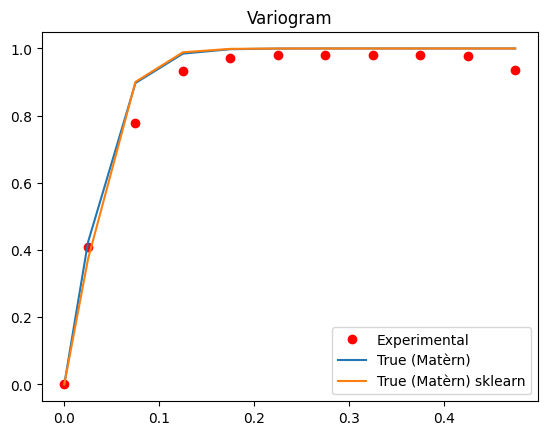

In [45]:
plt.plot(
    varexp[:, 0],
    varexp[:, 1],
    marker="o",
    label="Experimental",
    c="r",
    linestyle="None",
)
# mat_val = matern(varexp[1:, 0], alpha, kappa, spatial_dim)
# mat_val = np.insert(mat_val, 0, values=0, axis=0)

mat_val2 = 1 - matern_kernel(varexp[0:, 0], 1/kappa, 2 * alpha - spatial_dim / 2)

plt.plot(varexp[:, 0], mat_val2, label="True (Matèrn)")
plt.plot(varexp[:, 0], sk_matern(varexp[:, 0], kappa, alpha, spatial_dim), label="True (Matèrn) sklearn")
plt.title("Variogram")
plt.legend()
plt.show()

## Solution precision matrix

The precision matrix $\bm{Q}$ of $\bm{Z}$ (i.e. the inverse of its covariance matrix) reads :

$\bm{Q} = (dx \times dy)\bm{A}^{T}\bm{A}$

$\bm{Q}$ is thus a sparse matrix, whose expression is entirely determined by the discretization of the differential operator.

Note: now we consider alpha and the variance correction factor.

In [99]:
def get_precision_matrix(nx: int, ny: int, dx: float, dy: float, kappa: NDArrayFloat, alpha: int, spatial_dim: int, is_use_mass_lumping: bool = True) -> csc_matrix:
    """
    Get the precision matrix for the given SPDE field parameters.

    Parameters
    ----------
    nx : int
        Number of meshes along x.
    ny : int
        Number of meshes along y.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    kappa : NDArrayFloat
        SPDE parameter linked to the inverse of the correlation range of the covariance 
        function. Real strictly 
        positive.
    alpha : int
        SPDE parameter linked to the field regularity.
    spatial_dim : int
        Spatial dimension of the grid (1, 2 or 3).
    is_use_mass_lumping: bool
        Approximate the matrix power. The default is True.

    Returns
    -------
    csc_matrix
        The sparse precision matrix.
    """

    # Discretization of (kappa^2 - Delta)^(alpha)
    # Build the laplacian matrix: (kappa^2 - Delta)
    A: csc_matrix = get_laplacian_matrix(nx, ny, dx, dy, kappa)

    # Apply alpha (we deal only with integers alpha)
    if is_use_mass_lumping:
        Af = scipy.sparse.identity(A.shape[0])
    else:
        Af = A
    
    # Use mass lumping
    for i in range(alpha):
        # Af = A @ Af  # matrix multiplication
        Af = A @ Af

    # Correction factor for variance
    nu = 2 * alpha - spatial_dim / 2
    tau = (kappa**(nu))*np.sqrt((4*np.pi)*np.math.gamma(2*alpha)/np.math.gamma(nu))   

    # Calculate precision matrix
    Af = (np.sqrt((dx*dy))*Af).multiply(1/tau)
    return Af.T @ Af 

In [60]:
alpha1 = 1
nu1 = 2 * alpha1 - spatial_dim / 2
Q_a1 = get_precision_matrix(nx, ny, dx, dy, kappa, alpha1, spatial_dim=field_dimension)
alpha2 = 2
nu2 = 2 * alpha2 - spatial_dim / 2
Q_a2 = get_precision_matrix(nx, ny, dx, dy, kappa, alpha2, spatial_dim=field_dimension)
alpha3 = 3
nu3 = 2 * alpha3 - spatial_dim / 2
Q_a3 = get_precision_matrix(nx, ny, dx, dy, kappa, alpha3, spatial_dim=field_dimension)

- Check the sparcity

In [48]:
logging.info(f"Q_a1 sparcity = {Q_a1.count_nonzero() / np.product(Q_a1.shape)*100}%")
logging.info(f"Q_a2 sparcity = {Q_a2.count_nonzero() / np.product(Q_a2.shape)*100}%")
logging.info(f"Q_a3 sparcity = {Q_a3.count_nonzero() / np.product(Q_a3.shape)*100}%")

INFO:root:Q_a1 sparcity = 0.1164495867768595%
INFO:root:Q_a2 sparcity = 0.36236363636363633%
INFO:root:Q_a3 sparcity = 0.7413719008264463%


## Non conditional simulation from precision matrix

In [49]:
def simu_nc2(
    cholQ: Factor,
    rng: np.random.Generator,
) -> NDArrayFloat:
    """
    Return the gaussian solution of the discretized EDPS (gaussian vector).

    Parameters
    ----------
    cholQ : Factor
        The cholesky factorization of precision matrix.
    rng: np.random.Generator
        Random number generator.
        
    Returns
    -------
    NDArrayFloat
        The simulation.

    """
    w = rng.normal(size=cholQ.L().shape[0]) # white noise
    return cholQ.apply_Pt(cholQ.solve_Lt(1./np.sqrt(cholQ.D()) * w))

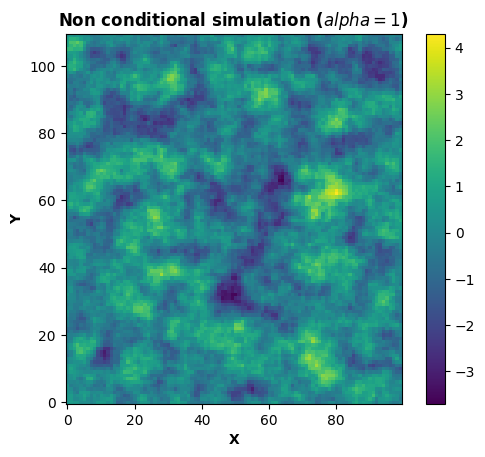

In [50]:
cholQ_a1 = cholesky(Q_a1.tocsc())
z_nc_a1 = simu_nc2(cholQ_a1, rng)

plt.imshow(z_nc_a1.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Non conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

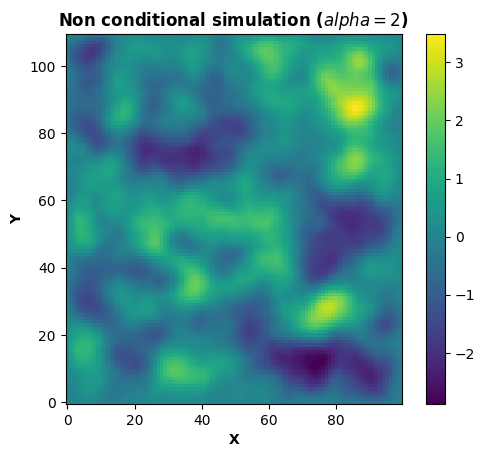

In [51]:
cholQ_a2 = cholesky(Q_a2.tocsc())
z_nc_a2 = simu_nc2(cholQ_a2, rng)

plt.imshow(z_nc_a2.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Non conditional simulation ($alpha=2$)", fontweight="bold")
plt.colorbar()

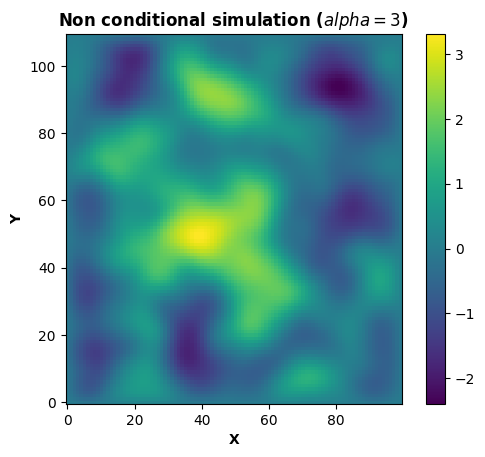

In [52]:
cholQ_a3 = cholesky(Q_a3.tocsc())
z_nc_a3 = simu_nc2(cholQ_a3, rng)

plt.imshow(z_nc_a3.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Non conditional simulation ($alpha=3$)", fontweight="bold")
plt.colorbar()

In [53]:
Q_a1

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 140904 stored elements in Compressed Sparse Row format>

In [54]:
Q_a2

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 438460 stored elements in Compressed Sparse Row format>

In [55]:
Q_a3

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 897060 stored elements in Compressed Sparse Row format>

- As for the previous approach, calculation of the average over several simulations of the experimental variogram

In [56]:
nb_sim = 100  # nomber of simulations
varexp_alpha1 = 0
varexp_alpha2 = 0
varexp_alpha3 = 0

for i in range(nb_sim):
    z0_1 = simu_nc2(cholQ_a1, rng)
    z0_2 = simu_nc2(cholQ_a2, rng)
    z0_3 = simu_nc2(cholQ_a3, rng)
    varexp_alpha1 = varexp_alpha1 + get_exp_var(z0_1, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    varexp_alpha2 = varexp_alpha2 + get_exp_var(z0_2, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim
    varexp_alpha3 = varexp_alpha3 + get_exp_var(z0_3, n0, lag, nbpts, nx, ny, dx, dy, rng) / nb_sim

# Add the point (0.0) to varexp -> no nugget effect here
varexp_alpha1 = np.insert(varexp_alpha1, 0, values=0, axis=0)
varexp_alpha2 = np.insert(varexp_alpha2, 0, values=0, axis=0)
varexp_alpha3 = np.insert(varexp_alpha3, 0, values=0, axis=0)

- Plot the experiemental variogram vs. the theoretical one

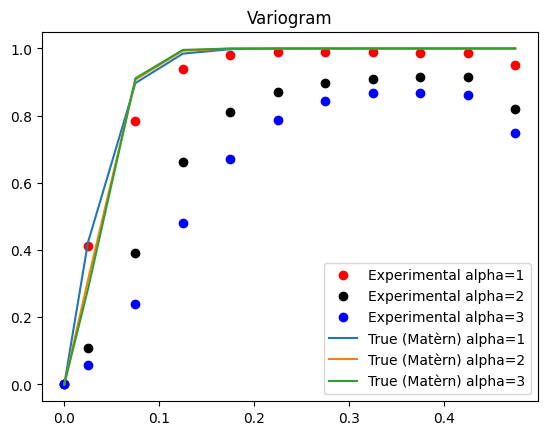

In [70]:
plt.plot(
    varexp_alpha1[:, 0],  varexp_alpha1[:, 1],
    marker="o",
    label="Experimental alpha=1",
    c="r",
    linestyle="None",
)
plt.plot(
    varexp_alpha2[:, 0],  varexp_alpha2[:, 1],
    marker="o",
    label="Experimental alpha=2",
    c="k",
    linestyle="None",
)
plt.plot(
    varexp_alpha3[:, 0],  varexp_alpha3[:, 1],
    marker="o",
    label="Experimental alpha=3",
    c="b",
    linestyle="None",
)


mat_val_a1 = 1 - matern_kernel(varexp_alpha1[:, 0], 1/kappa, nu1)
mat_val_a2 = 1 - matern_kernel(varexp_alpha2[:, 0], 1/kappa, nu2)
mat_val_a3 = 1 - matern_kernel(varexp_alpha3[:, 0], 1/kappa, nu3)

plt.plot(varexp_alpha1[:, 0], mat_val_a1, label="True (Matèrn) alpha=1")
plt.plot(varexp_alpha2[:, 0], mat_val_a2, label="True (Matèrn) alpha=2")
plt.plot(varexp_alpha3[:, 0], mat_val_a3, label="True (Matèrn) alpha=3")
plt.title("Variogram")
plt.legend()
plt.show()

## Case of varying correlation range ($\kappa$)

- Function for linear_gradient

In [76]:
def linear_gradient(coords: NDArrayFloat, val_min: float, val_max: float) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    coords : NDArrayFloat
        Points coordinates (2, npts).
    vlr_min : float
        Minimum gradient value.
    val_max : float
        Maximum gradient value.

    Returns
    -------
    NDArrayFloat
        The gradient.
    """

    return(np.exp(np.log(val_min)+(np.log(val_max)-np.log(val_min))*coords[:, 0]))

In [75]:
def create_grid_coordinates(shape: NDArrayInt, mesh_dim: NDArrayFloat) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    shape : NDArrayInt
        _description_
    mesh_dim : NDArrayFloat
        _description_

    Returns
    -------
    NDArrayFloat
        _description_
    """
    xmin: NDArrayFloat = np.array((mesh_dim)) / 2.0
    xmax = (np.array(shape) - 0.5) * mesh_dim
    
    x1 = np.linspace(xmin[0], xmax[0], shape[0])
    x2 = np.linspace(xmin[1], xmax[1], shape[1])
    xx, yy = np.meshgrid(x1, x2, indexing="ij")
    return np.vstack((np.ravel(xx, order="F"), np.ravel(yy, order="F"))).transpose()

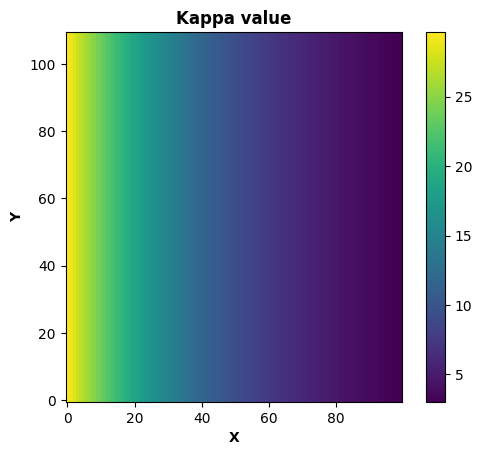

In [106]:
coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
varying_kappa = 1/linear_gradient(coords, val_min=1/kappa, val_max=1/kappa * 10.0)

plt.imshow(varying_kappa.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Kappa value", fontweight="bold")
plt.colorbar()

- Create the precision matrices

In [107]:
alpha4 = alpha1
nu4 = 2 * alpha1 - spatial_dim / 2
Q_a4 = get_precision_matrix(nx, ny, dx, dy, varying_kappa, alpha4, spatial_dim=field_dimension)

In [108]:
Q_a4

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 140904 stored elements in Compressed Sparse Row format>

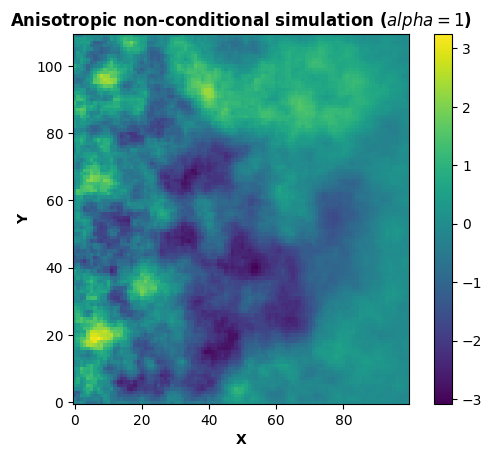

In [109]:
cholQ_a4 = cholesky(Q_a4.tocsc())
z_nc_a4 = simu_nc2(cholQ_a4, rng)

plt.imshow(z_nc_a4.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

## Dealing with anisotropies

In [628]:
def get_laplacian_matrix(
    nx: int, ny: int, dx: float, dy: float, kappa: Union[NDArrayFloat, float], anisotropy_function: Optional[Callable[[float, float], NDArrayFloat]] = None
) -> csc_matrix:
    """
    Return a sparse matrix of the discretization of the Laplacian.

    Parameters
    ----------
    nx : int
        Number of meshes along x.
    ny : int
        Number of meshes along y.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    kappa : float
        Range (length scale).
    anisotropy_function: Optional[Callable[[float, float], NDArrayFloat]]
        Anisotropy function that returns a 2d transformation value for a given 
        position (x, y). The default is None.

    Returns
    -------
    csc_matrix
        Sparse matrix with dimension (nx * ny)x(nx * ny) representing the  discretized
        laplacian.

    """
    n_nodes = nx * ny
    if np.isscalar(kappa):
        _kappa = np.full(n_nodes, fill_value=kappa)
    else:
        _kappa = np.array(kappa)

    if anisotropy_function is None:
        def _anifct(x: float, y: float) -> NDArrayFloat:
            return np.eye(2)
    else:
        _anifct = anisotropy_function

    # construct an empty sparse matrix (lil_format because it supports indexing and
    # slicing).
    lap = lil_matrix((n_nodes, n_nodes), dtype=np.float64)

    # Looping on all nodes and considering neighboors
    for i in range(nx):
        for j in range(ny):

            # For the owner node itself:
            node_index = indices_to_node_number(i, nx, j)
            _x, _y = (i + 0.5) * dx, (j + 0.5) * dy
            lap[node_index, node_index] += _kappa[node_index] ** 2 * dx * dy + dy / dx * (_anifct(_x + 0.5 * dx, _y)[0][0] + _anifct(_x - 0.5 * dx, _y)[0][0]) + dx / dy * (_anifct(_x, _y + 0.5 * dy)[1][1] + _anifct(_x, _y  - 0.5 * dy)[1][1])
            
            # The four closest neighbours:
            if i > 0: 
                neighbor_index = indices_to_node_number(i - 1, nx, j)
                lap[node_index, neighbor_index] -= (dy / dx * _anifct(_x - 0.5 * dx, _y)[0, 0] -1.0 / 4.0 * (_anifct(_x, _y + 0.5 * dx)[0, 1] - _anifct(_x, _y  - 0.5 * dx)[0, 1]))
            if i < nx - 1:
                neighbor_index = indices_to_node_number(i + 1, nx, j)
                lap[node_index, neighbor_index] -= (dy / dx  * _anifct(_x + 0.5 * dx, _y)[0, 0] +1.0 / 4.0 * (_anifct(_x, _y  + 0.5 * dx)[0, 1] - _anifct(_x, _y - 0.5 * dx)[0, 1]))
            if j < ny - 1:
                neighbor_index = indices_to_node_number(i, nx, j + 1)
                lap[node_index, neighbor_index] -= (dx / dy  * _anifct(_x, _y + 0.5 * dy)[1, 1] +1.0 / 4.0 * (_anifct(_x  + 0.5 * dx, _y)[1, 0] - _anifct(_x  - 0.5 * dx, _y)[1, 0]))
            if j > 0:
                neighbor_index = indices_to_node_number(i, nx, j - 1)
                lap[node_index, neighbor_index] -= (dx / dy  * _anifct(_x, _y - 0.5 * dy)[1, 1] -1.0 / 4.0 * (_anifct(_x  + 0.5 * dx, _y)[1, 0] - _anifct(_x  - 0.5 * dx, _y)[1, 0]))
 
            # Lastly, the four diagonally closest neighbours:
            if i > 0 and j > 0: 
                neighbor_index = indices_to_node_number(i - 1, nx, j - 1)
                lap[node_index, neighbor_index] -= 1.0 / 4.0 * (_anifct(_x, _y  - 0.5 * dy)[0, 1] + _anifct(_x  - 0.5 * dx, _y)[1, 0])
            if i < nx - 1 and j > 0:
                neighbor_index = indices_to_node_number(i + 1, nx, j - 1)
                lap[node_index, neighbor_index] += 1.0 / 4.0 * (_anifct(_x, _y  - 0.5 * dy)[0, 1] + _anifct(_x  + 0.5 * dx, _y)[1, 0])
            if i > 0 and j < ny - 1:
                neighbor_index = indices_to_node_number(i - 1, nx, j + 1)
                lap[node_index, neighbor_index] += 1.0 / 4.0 * (_anifct(_x, _y  + 0.5 * dy)[0, 1] + _anifct(_x  - 0.5 * dx, _y)[1, 0])
            if i < nx - 1 and j < ny - 1:
                neighbor_index = indices_to_node_number(i + 1, nx, j + 1)
                lap[node_index, neighbor_index] -= 1.0 / 4.0 * (_anifct(_x, _y  + 0.5 * dy)[0, 1] + _anifct(_x  + 0.5 * dx, _y)[1, 0])
            


    # Convert from lil to csr matrix for more efficient calculation
    return lap.tocsc()
    
def get_precision_matrix(nx: int, ny: int, dx: float, dy: float, kappa: NDArrayFloat, alpha: int, spatial_dim: int, is_use_mass_lumping: bool = True, anisotropy_function: Optional[Callable[[float, float], NDArrayFloat]] = None) -> csc_matrix:
    """
    Get the precision matrix for the given SPDE field parameters.

    Parameters
    ----------
    nx : int
        Number of meshes along x.
    ny : int
        Number of meshes along y.
    dx : float
        Size of the mesh along x.
    dy : float
        Size of the mesh along y.
    kappa : NDArrayFloat
        SPDE parameter linked to the inverse of the correlation range of the covariance 
        function. Real strictly 
        positive.
    alpha : int
        SPDE parameter linked to the field regularity.
    spatial_dim : int
        Spatial dimension of the grid (1, 2 or 3).
    is_use_mass_lumping: bool
        Approximate the matrix power. The default is True.
    anisotropy_function: Optional[Callable[[float, float], NDArrayFloat]]
        Anisotropy function that returns a 2d transformation value for a given 
        position (x, y). The default is None.

        
    Returns
    -------
    csc_matrix
        The sparse precision matrix.
    """

    # Discretization of (kappa^2 - Delta)^(alpha)
    # Build the laplacian matrix: (kappa^2 - Delta)
    A: csc_matrix = get_laplacian_matrix(nx, ny, dx, dy, kappa, anisotropy_function=anisotropy_function)

    # Apply alpha (we deal only with integers alpha)
    if is_use_mass_lumping:
        Af = scipy.sparse.identity(A.shape[0])
    else:
        Af = A
    
    # Use mass lumping
    for i in range(alpha):
        # Af = A @ Af  # matrix multiplication
        Af = A @ Af

    # Correction factor for variance
    nu = 2 * alpha - spatial_dim / 2
    tau = (kappa**(nu))*np.sqrt((4*np.pi)*np.math.gamma(2*alpha)/np.math.gamma(nu))   

    # Calculate precision matrix
    Af = (np.sqrt((dx*dy))*Af).multiply(1/tau)
    return Af.T @ Af 

In [705]:
gamma = 1.0
beta = 8.0
theta = 2 * np.pi / 4
v = np.array([np.cos(theta), np.sin(theta)]).T

# TODO: maybe use a cache function ???

H = gamma * np.eye(2) + beta * v[:, np.newaxis] * v[:, np.newaxis].T
def _example31(x: float, y: float) -> NDArrayFloat:
    """Return a matrix."""
    return H.T

In [706]:
Q_test = get_precision_matrix(200, 200, 0.1, 0.1, 1.0, 1, 2, True)

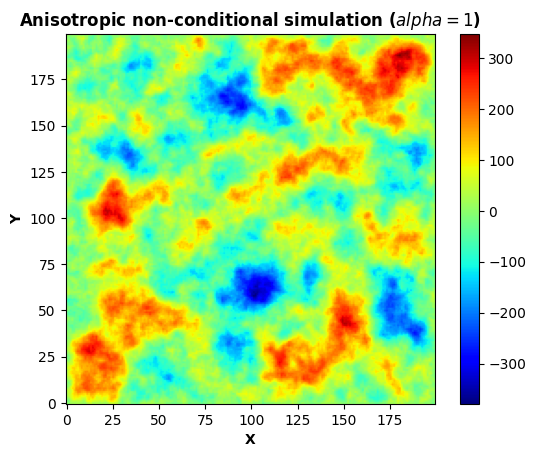

In [707]:
cholQ_test = cholesky(Q_test.tocsc())
z_nc_test = simu_nc2(cholQ_test, rng)

plt.imshow(z_nc_test.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [708]:
Q_ex31 = get_precision_matrix(200, 200, 0.1, 0.1, 1.0, 1, 2, True, anisotropy_function=_example31)

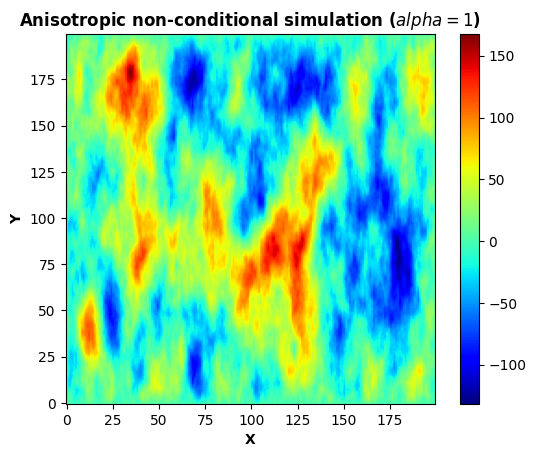

In [709]:
cholQ_ex31 = cholesky(Q_ex31.tocsc())
z_nc_ex31 = simu_nc2(cholQ_ex31, rng)

plt.imshow(z_nc_ex31.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

## Anisotropies in the non-stationary case

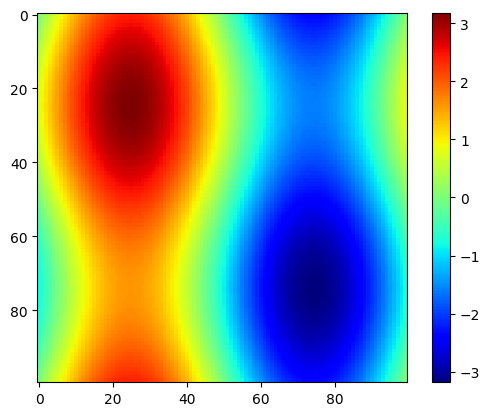

In [710]:
def _example32(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return 10 / np.pi  * (3.0 / 4.0 * np.sin(2 * np.pi * x / 20.0) + 1.0 / 4.0 * np.sin(2 * np.pi * y / 20.0))

X, Y = np.meshgrid(np.linspace(0, 20, 100), np.linspace(0, 20, 100))

field = _example32(X, Y)

plt.imshow(field, cmap="jet")
plt.colorbar()

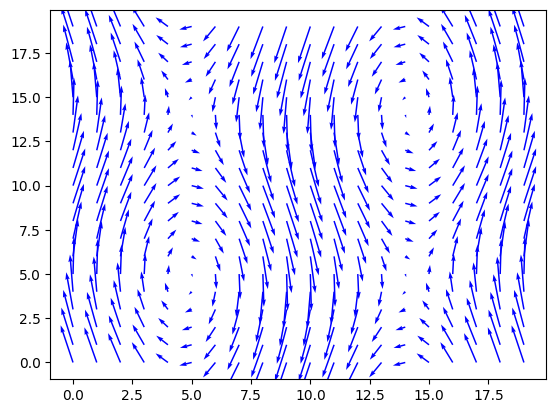

In [711]:
def _example32_gradient(x: float, y: float) -> float:
    """
    Return values to create a vector field.

    Parameters
    ----------
    x : float
        Position in meters.
    y : float
        Position in meters.

    Returns
    -------
    float
        Value
    """
    return 10 / np.pi * np.array([
        -1.0 / 4.0 * np.cos(2 * np.pi * y / 20.0) * 2 * np.pi / 20.0,
        3.0 / 4.0 * np.cos(2 * np.pi * x / 20.0) * 2 * np.pi / 20.0
        ])
    
X, Y = np.meshgrid(np.linspace(0, 20, 20), np.linspace(0, 20, 20))
gradient_field = _example32_gradient(X, Y)

plt.quiver(gradient_field[0], gradient_field[1], scale=10, color="blue")


In [719]:
def _wrapper_ex32(x: float, y: float) -> NDArrayFloat:
    v = _example32_gradient(x, y)
    return (0.1 * np.eye(2) + 25 * v[:, np.newaxis] * v[:, np.newaxis].T).T

In [720]:
_wrapper_ex32(4, 7)

array([[0.63983047, 0.85141703],
       [0.85141703, 1.44284926]])

In [721]:
_wrapper_ex32(7, 20.0)

array([[1.6625    , 2.75524337],
       [2.75524337, 4.95847426]])

In [722]:
Q_ex32 = get_precision_matrix(200, 200, 0.1, 0.1, 1.0, 1, 2, True, anisotropy_function=_wrapper_ex32)

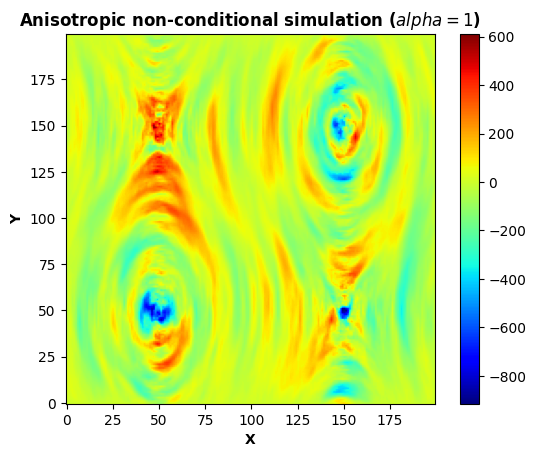

In [723]:
cholQ_ex32 = cholesky(Q_ex32.tocsc())
z_nc_ex32 = simu_nc2(cholQ_ex32, rng)

plt.imshow(z_nc_ex32.reshape(200, 200), origin="lower", cmap="jet")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Anisotropic non-conditional simulation ($alpha=1$)", fontweight="bold")
plt.colorbar()

In [724]:
raise ValueError

ValueError: 

## Kriging (case of $\alpha = 2$)

The kriging $\bm{Z}^{T}_{K}$ can be obtained from

$\bm{Z}^{K}_{T} = - (\bm{Q}_{TT})^{-1} \bm{Q}_{TD} \bm{Z}_{D}$ with $\bm{Q} = \begin{pmatrix}
  \bm{Q}_{DD} & \bm{Q}_{DT}\\ 
  \bm{Q}_{TD} & \bm{Q}_{TT}
\end{pmatrix}$, the precision matrix of $\bm {Z}$.

Then the linear system needs to be solved:

$\bm{Q}_{TT} \bm{Z}^{K}_{T} = - \bm{Q}_{TD} \bm{Z}_{D}$

It is done using the Cholesky decomposition of $\bm{Q}_{TT}$

1) Compute $L$ with the decomposition $\bm{Q}_{TT} = \bm{LL}^{T}$
2) Solve the linear system $\bm{LX} = - \bm{Q}_{TD} \bm{Z}_{D}$
3) Solve the linear system $\bm{L}\bm{Z}^{K}_{T} = \bm{X}$

- We sample the previous non conditional simulation (200 data points) and plot it

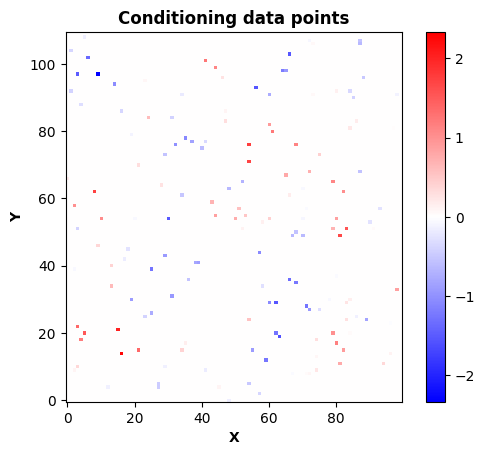

In [ ]:
# Indices of data points (D)  -> 150 points
indexes_dat = np.sort(rng.choice(nx * ny, size=150, replace=False))

# Also select points regularly along a certain line (to be sure we have enough points to vizualize later on)
id_check_row = 50  # index of a line
id_check_sel_all= np.arange(0, nx) + (id_check_row - 1) * ny # indices along this lines
id_check_sel_dat=  np.arange(0, nx, step=10) + (id_check_row - 1) * ny # indices along this row (every 10 points)

# Merge the indexes_dat + delete duplicates
indexes_dat = np.unique(np.hstack([indexes_dat, id_check_sel_dat]))

# Indices of unknonws (targets - T) -> 9800 points
indexes_tar = np.delete(np.arange(nx * ny), indexes_dat)

# Vector of data (Z_D)
dat = z_nc_a2[indexes_dat]

# Display the data in the grid
dat_pts = np.zeros((nx * ny))  # 1D empty array
dat_pts[indexes_dat] = dat
# Plot the data points (make it 2D with reshape)
plt.imshow(
    dat_pts.reshape(ny, nx), cmap=plt.get_cmap("bwr"), norm=colors.CenteredNorm(), origin="lower"
)
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Conditioning data points", fontweight="bold")
plt.plot()
plt.colorbar()

- Define a matrix for advanced and efficient slicing of sparse matrices

In [ ]:
def slice_sparse(A: csc_matrix, row_indexes: NDArrayInt, col_indexes: NDArrayInt) -> csc_matrix:
    B = A.tocsc()  # or `.tocsr()`
    B = B[np.array(row_indexes)[:, np.newaxis], np.array(col_indexes)]
    return B

- QTD sub-matrix from the precision matrix (9800 * 200)

In [ ]:
QTD_a2: csc_matrix = slice_sparse(Q_a2, indexes_tar, indexes_dat)
QTD_a2.shape

(10840, 160)

- QTT sub-matrix from the precision matrix (9800 * 9800)

In [ ]:
QTT_a2 = slice_sparse(Q_a2, indexes_tar, indexes_tar)
QTT_a2

<10840x10840 sparse matrix of type '<class 'numpy.float64'>'
	with 425852 stored elements in Compressed Sparse Column format>

-  Cholesky factorization of QTT

In [ ]:
QTT_factor_a2 = cholesky(QTT_a2)

- Write a function for the process

In [ ]:
def decompose_precison_matrix(Q: csc_matrix, indexes_dat: NDArrayInt, indexes_tar: NDArrayInt) -> Tuple[csc_matrix, Factor]:
    
    QTD: csc_matrix = slice_sparse(Q, indexes_tar, indexes_dat)
    QTT_factor = cholesky(slice_sparse(Q, indexes_tar, indexes_tar))

    return QTD, QTT_factor

- Define a function that returns a kriggin

In [ ]:
def krig_chol(QTT_factor: Factor, QTD: csc_matrix, dat: NDArrayFloat , indexes_dat: NDArrayInt) -> NDArrayFloat:
    """
    Returns the kriging fo the component of a gaussian vector.

    Parameters
    ----------
    QTT_factor: Factor
        Cholesky factorization of QTT sub matrix.
    QTD : csc_matrix
        QTD sub matrix of Q.
    dat : NDArrayFloat
        Known data values.
    indexes_dat : NDArrayInt
        Known data indices in the grid.

    Returns
    -------
    NDArrayFloat
    Vector of kriged values.
    """
    right_term =  - QTD.dot(dat)

    # Direct way
    zT_k=QTT_factor(right_term)
    # this is a wrapping for: zT_k=QTT_factor.solve_A(right_term)

    # Note; this is like doing:
    # zT_k = QTT_factor.apply_Pt(QTT_factor.solve_LDLt(QTT_factor.apply_P(right_term)))
    
    # Build the output vector
    nb_nodes=np.sum(QTD.shape)
    z_k=np.zeros(nb_nodes)
    # Affect the known values
    z_k[indexes_dat] = dat
    # Affect the kriged values
    indexes_tar = np.delete(np.arange(nb_nodes), indexes_dat)
    z_k[indexes_tar] = zT_k

    return(z_k)


In [ ]:
z_k_a2 = krig_chol(QTT_factor_a2, QTD_a2, dat, indexes_dat)

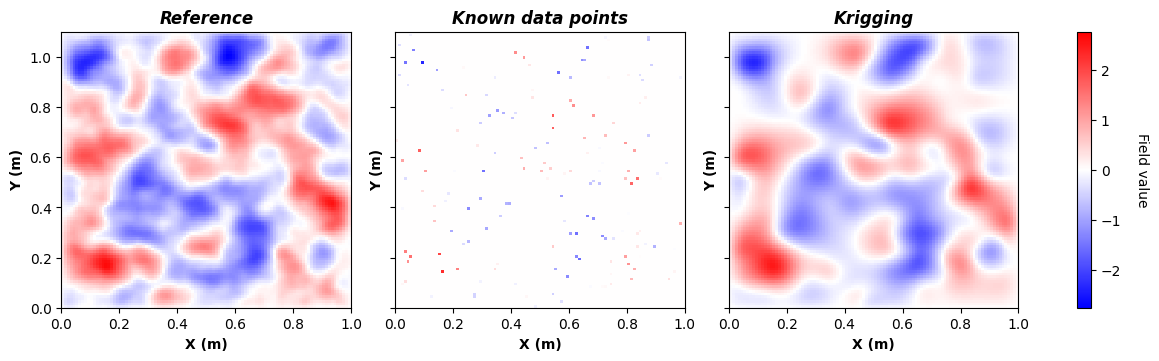

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11.5, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

## Conditional simulation

A conditional simulation of $\bm{Z}$ can be obtained in three times:

- Generate a non conditional simulation $\bm{Z}_{NC}$ of $\bm{Z}$
- Compute the kirging $\bm{Z}^{K}_{NC}$ of the values of the non conditional simulation $\bm{Z}_{NC}$ at the data points.
- Generate a conditional simulation with the formula

$\bm{Z}_{C} =  \bm{Z}^{K} + (Z_{NC} - \bm{Z}^{K}_{NC})$

- Other non conditional simulation

In [ ]:
z_nc_new = simu_nc2(cholQ_a2, nx * ny, rng)
dat_nc_new = z_nc_new[indexes_dat]
z_nck_new = krig_chol(QTT_factor_a2, QTD_a2, dat_nc_new, indexes_dat)

In [ ]:
z_c_a2 = z_k_a2 - (z_nc_new - z_nck_new)

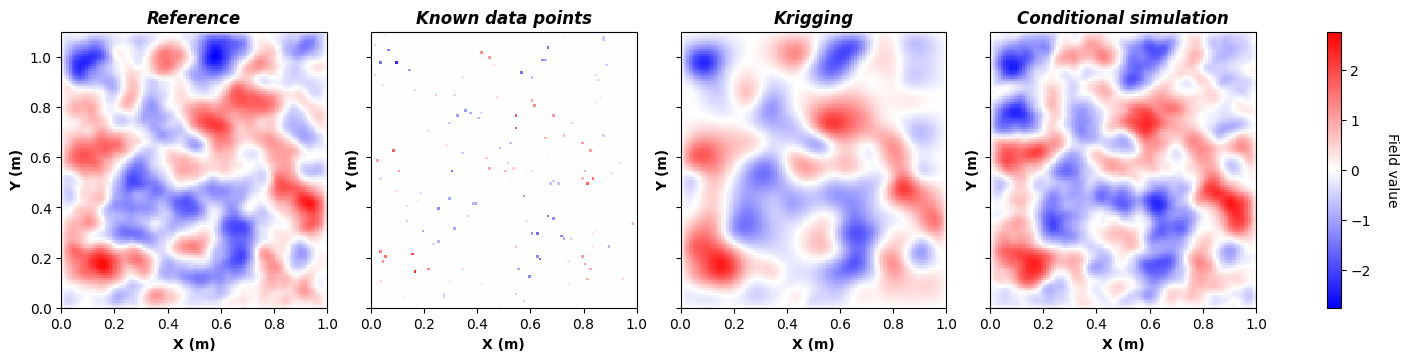

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3", 'axes1-4']], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
        "Conditional simulation": z_c_a2.reshape(ny, nx).T
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

- Check that the data points are honored (the difference should be zero)

In [ ]:
z_c_a2[indexes_dat] - dat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

- General method to achieve that (note that the Cholesky decomposition is applied before, so that the method could be called a great number of times)

In [ ]:
def simu_cond(cholQ: Factor, QTT_factor: Factor, QTD: csc_matrix, dat: NDArrayFloat, indexes_dat: NDArrayInt, rng) -> NDArrayFloat:
    z_k = krig_chol(QTT_factor, QTD, dat, indexes_dat)
    z_nc = simu_nc2(cholQ, z_k.size, rng)
    dat_nc = z_nc[indexes_dat]
    z_nck = krig_chol(QTT_factor, QTD, dat_nc, indexes_dat)
    return z_k - (z_nc - z_nck)

- Test the function and plot the results

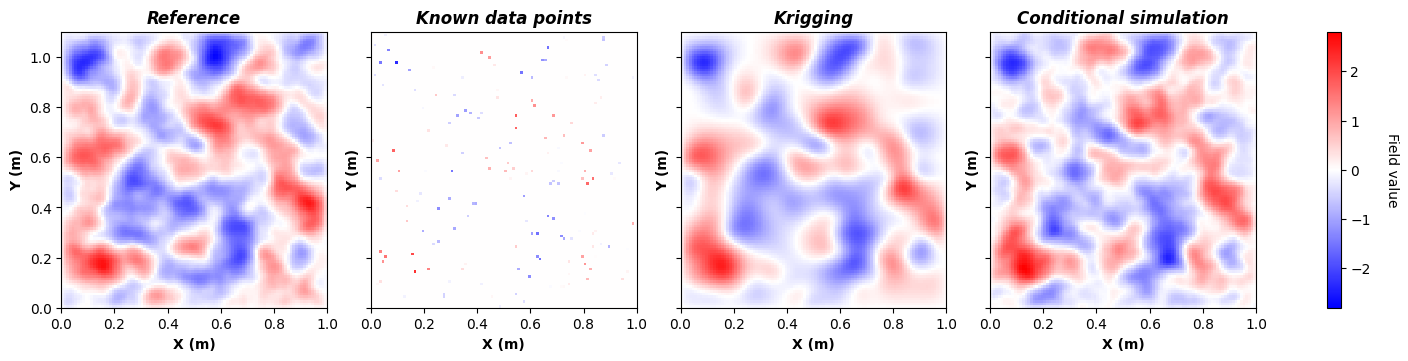

In [ ]:
z_c_a2_test = simu_cond(cholQ_a2, QTT_factor_a2, QTD_a2, dat, indexes_dat, rng)

plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3", 'axes1-4']], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
        "Conditional simulation": z_c_a2_test.reshape(ny, nx).T
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

- Should also be zero everywhere

In [ ]:
z_c_a2_test[indexes_dat] - dat

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

## Considering data points uncertainty

- Create a function to generate an artificial variance on the domain

In [ ]:
def reversed_beta_cumulative(x: NDArrayFloat, beta: float = 3) -> NDArrayFloat:
    """
    Transform the input with 1/ (1 + (1 / (1 - x)) ^ beta)

    Parameters
    ----------
    x : np.ndarray
        Input array. Idealy, values should be between 0. and 1.0.
    beta: float, optional
        Shape factor. Must be strictly positive. The default is 3.

    Returns
    -------
    np.ndarray.
        Array of same dimension as input array.

    """
    if beta <= 0:
        raise ValueError(f"Beta ({beta}) should be strictly positive !")

    x2 = x.copy()
    x2[x <= 0] = np.nan
    x2[x >= 1] = np.nan
    fact = np.where(np.isnan(x2), 0.0, 1.0 / (1.0 + np.power((x2 / (1 - x2)), -beta)))
    fact[x >= 1] = 1
    return 1 - fact

def create_variance_circle(coords: NDArrayFloat, var_min: float, var_max: float, beta: float, scaling_factor: float) -> NDArrayFloat:
    """_summary_

    Parameters
    ----------
    coords : NDArrayFloat
        Points coordinates (2, npts).
    var_min : float
        _description_
    var_max : float
        _description_

    Returns
    -------
    NDArrayFloat
        _description_
    """
    center_x = (np.max(coords[:, 0]) - np.min(coords[:, 0])) / 2
    center_y = (np.max(coords[:, 1]) - np.min(coords[:, 1])) / 2
    r = np.sqrt((coords[:, 0] - center_x) ** 2 + (coords[:, 1] - center_y) ** 2) / scaling_factor
    return var_min + var_max * reversed_beta_cumulative(r, beta)


- Plot an example of variance map (linear variation)

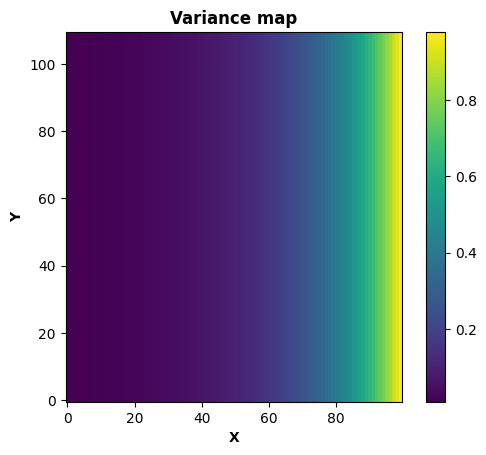

In [ ]:
coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
grid_var = linear_gradient(coords, val_min=0.1**2, var_mal=1.0**2)

plt.imshow(grid_var.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Variance map", fontweight="bold")
plt.colorbar()

- Plot an example of variance map (circle version)

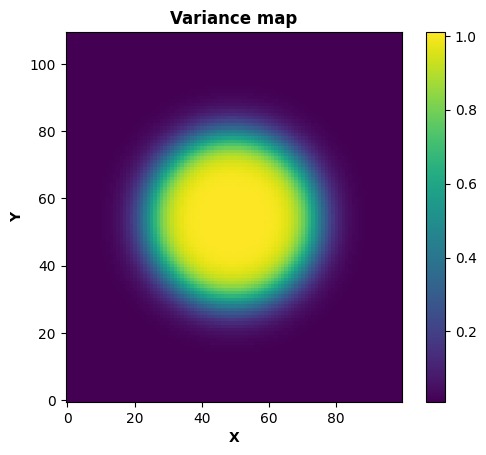

In [ ]:
coords = create_grid_coordinates(np.array([nx, ny]), np.array([dx, dy]))
grid_var = create_variance_circle(coords, var_min=0.1**2, var_max=1.0**2, beta=4, scaling_factor=.5)

plt.imshow(grid_var.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Variance map", fontweight="bold")
plt.colorbar()


In [ ]:
def condition_precision_matrix(Q: csc_matrix, indices_dat: NDArrayInt, var_dat: NDArrayFloat) -> csc_matrix:
    """
    Condition the precision matrix with the variance of known data points.

    Parameters
    ----------
    Q : csc_matrix
        _description_
    indices_dat : NDArrayInt
        _description_
    var_dat : NDArrayFloat
        _description_

    Returns
    -------
    csc_matrix
        The conditionned precision matrix.
    """
    # Build the diagonal matrix containing the inverse of the error variance at known 
    # data points
    
    diag_var = lil_matrix(Q.shape)
    diag_var[indexes_dat, indexes_dat] = 1 / var_dat
    return (diag_var + Q).tocsc()

### Krigging with uncertainty

In [ ]:
Q_a2_cond = condition_precision_matrix(Q_a2, indexes_dat, grid_var[indexes_dat])

In [ ]:
QTD_a2_cond, QTT_a2_cond_factor = decompose_precison_matrix(Q_a2_cond, indexes_dat, indexes_tar)

In [ ]:
def krig_prec2(Q: csc_matrix, dat: NDArrayFloat, indexes_dat: NDArrayInt, cholQ: Optional[Factor]=None, dat_var: Optional[NDArrayFloat]=None) -> NDArrayFloat:
    if cholQ is None:
        _cholQ = cholesky(Q.tocsc())
    else:
        _cholQ = cholQ
    input = np.zeros(Q.shape[0])
    input[indexes_dat] = dat 
    if dat_var is not None:
        input[indexes_dat] /= dat_var 
    return _cholQ(input)

In [ ]:
z_k_a2_cond = krig_prec2(Q_a2_cond, dat, indexes_dat, dat_var=grid_var[indexes_dat])

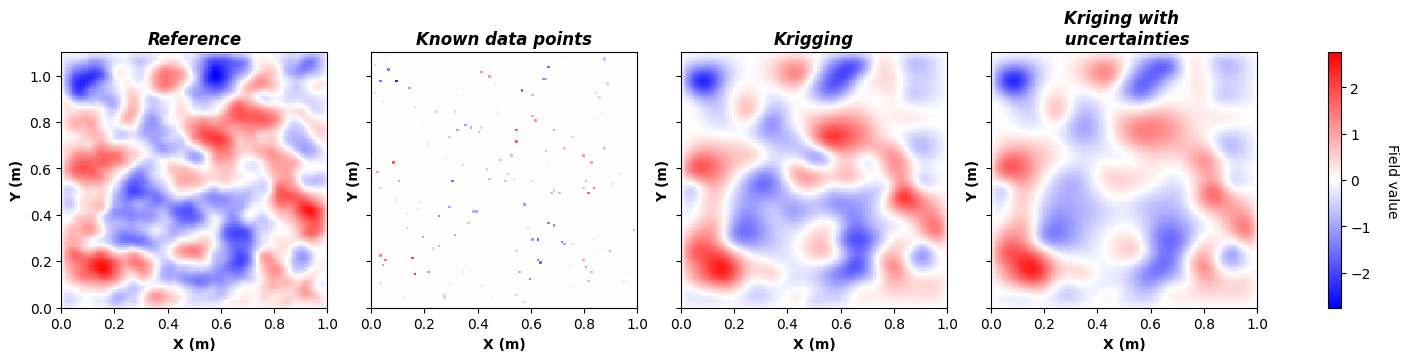

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3", 'axes1-4']], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "Known data points": dat_pts.reshape(ny, nx).T,
        "Krigging": z_k_a2.reshape(ny, nx).T,
        "Kriging with \n uncertainties": z_k_a2_cond.reshape(ny, nx).T
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

In [ ]:
z_k_a2 - z_k_a2_cond

array([-0.0103576 , -0.01940323, -0.02612661, ..., -0.00062277,
       -0.00033691, -0.00014571])

- We can see that the variance is espacially high

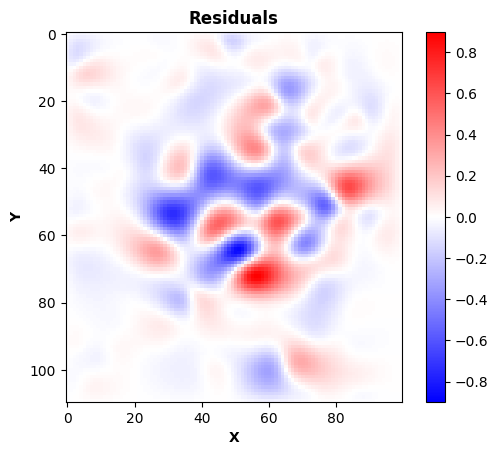

In [ ]:
plt.imshow((z_k_a2 - z_k_a2_cond).reshape(ny, nx), cmap = plt.get_cmap("bwr"), norm=colors.CenteredNorm())
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Residuals", fontweight="bold")
plt.colorbar()

## Conditional simulation with uncertainties

In [ ]:
def simu_cond_std(cholQ: Factor, Q_cond: csc_matrix, cholQ_cond: Factor, dat: NDArrayFloat, indexes_dat: NDArrayInt, rng) -> NDArrayFloat:
    z_k = krig_prec2(Q_cond, dat, indexes_dat, cholQ=cholQ_cond, dat_var=grid_var[indexes_dat])
    # z_k = krig_prec2(Q_cond, dat * 1 / grid_var[indexes_dat], indexes_dat)
    z_nc = simu_nc2(cholQ, z_k.size, rng)
    dat_nc = z_nc[indexes_dat]
    # z_nck = krig_chol(QTT_factor, QTD, dat_nc, indexes_dat)
    z_nck = krig_prec2(Q_cond, dat_nc, indexes_dat, cholQ=cholQ_cond, dat_var=grid_var[indexes_dat])
    return z_k - (z_nc - z_nck)

- Plot the values along a specific row + perform simulations

- performa conditional simulations taking into account the uncertainties on data points

In [ ]:
n_simu=100
simus = np.zeros((n_simu, nx * ny))

cholQ_a2 = cholesky(Q_a2.tocsc())
cholQ_a2_cond = cholesky(Q_a2_cond.tocsc())

for i in range(n_simu):
    simus[i, :] = simu_cond_std(cholQ_a2, Q_a2_cond, cholQ_a2_cond, dat, indexes_dat, rng)


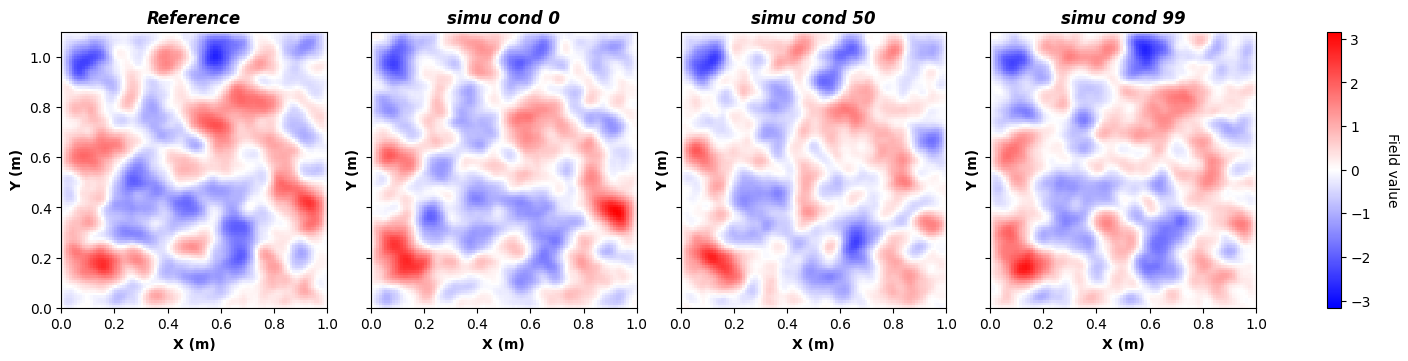

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (14, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3", 'axes1-4']], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Reference": z_nc_a2.reshape(ny, nx).T,
        "simu cond 0": simus[0, :].reshape(ny, nx).T,
        "simu cond 50": simus[50, :].reshape(ny, nx).T,
        "simu cond 99": simus[99, :].reshape(ny, nx).T,
    },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

- Plot one row

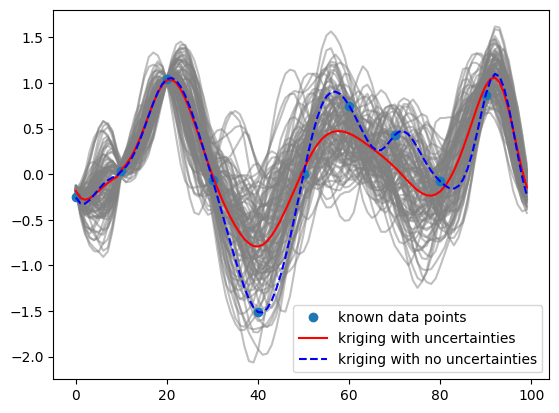

In [ ]:
plt.plot(simus[:, id_check_sel_all].T, color="grey", alpha=0.5)
plt.plot(np.arange(0, nx, step=10), z_k_a2[id_check_sel_dat], linestyle="none", marker="o", label="known data points")
plt.plot(z_k_a2_cond[id_check_sel_all], color="r", label="kriging with uncertainties")
plt.plot(z_k_a2[id_check_sel_all], color="b", label="kriging with no uncertainties", linestyle="--")
plt.legend()

- This time, the data points are not perfectly respected

In [ ]:
z_k_a2_cond[indexes_dat] - dat

array([ 8.00859241e-02,  1.44879850e-02,  1.48026951e-02,  8.55081038e-03,
       -2.92092775e-02, -2.81797607e-04, -1.01146555e-02, -2.07951297e-02,
        4.00407715e-03,  1.63806050e-02,  3.92944557e-02,  1.45435496e-02,
       -2.38652733e-02, -3.48782902e-02,  9.05860300e-03,  2.67173487e-03,
       -9.01170007e-03,  1.10826619e-02,  2.67363463e-02, -2.63381623e-02,
        1.39486598e-03,  5.19992893e-03, -4.19249247e-02,  8.02457435e-03,
       -2.46110057e-03,  3.52074073e-02, -3.19999509e-02,  4.37346194e-03,
       -6.90293485e-03,  8.73534659e-02,  2.13984358e-02, -9.33391965e-02,
       -9.26369253e-03,  3.03016482e-02, -1.25506245e-02, -4.42927221e-02,
       -1.91444310e-02, -2.38061330e-01,  6.38963199e-03,  6.19854015e-02,
       -8.42787983e-03, -5.88971124e-02,  1.46853475e-02, -3.21134483e-03,
        1.39758497e-03,  7.08641279e-02,  1.36831272e-01,  2.54783465e-01,
       -1.38587576e-02,  4.68025535e-02, -1.35108160e-02,  2.43516175e-02,
        2.52324639e-02, -

### Conditionnal simulation with uncertainty

## Regularization

From gaussian likelihood.

In [ ]:
def get_reg_loglikelihood(Qd: csc_matrix, param: NDArrayFloat, prior: NDArrayFloat) -> float:
    residuals = param - prior
    return 1/2 * np.dot(residuals.T, Qd.dot(residuals))

def get_reg_loglikelihood_gradient(Qd: csc_matrix, param: NDArrayFloat, prior: NDArrayFloat) -> NDArrayFloat:
    residuals = param - prior
    return Qd.dot(residuals)

### Test with the correct covariance function ($\alpha = 2$)

- The prior is null because we work directly with the residuals

In [ ]:
prior = np.zeros((nx * ny))

- Get the regularization with no data points to fit (only the variogram is encoded)

In [ ]:
get_reg_loglikelihood(Q_a2, z_k_a2_cond, prior)

41.07065194161061

- Get the regularization with the data points as a constraints

In [ ]:
get_reg_loglikelihood(Q_a2_cond, z_k_a2_cond, prior)

2862.5651906688254

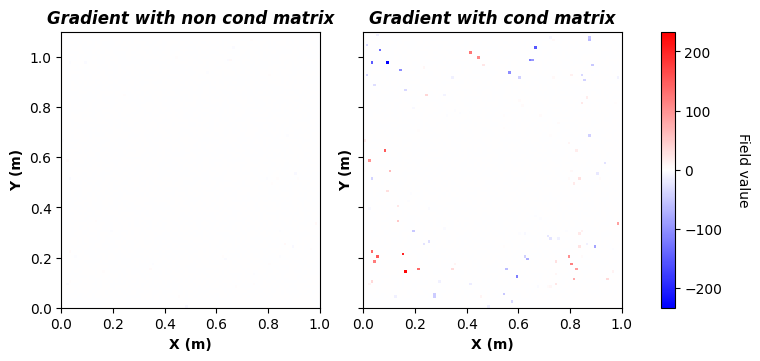

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (7.5, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Gradient with non cond matrix": get_reg_loglikelihood_gradient(Q_a2, z_k_a2_cond, prior).reshape(ny, nx).T,
        "Gradient with cond matrix": get_reg_loglikelihood_gradient(Q_a2_cond, z_k_a2_cond, prior).reshape(ny, nx).T,
        },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

### Test with the wrong covariance function ($\alpha = 1$)

- Generate a conditonal simulation but with $\alpha = 1$

In [ ]:
cholQ_a1 = cholesky(Q_a1.tocsc())
Q_a1_cond = condition_precision_matrix(Q_a1, indexes_dat, grid_var[indexes_dat])
cholQ_a1_cond = cholesky(Q_a1_cond.tocsc())

simu_cond_a1 = simu_cond_std(cholQ_a1, Q_a2_cond, cholQ_a2_cond, dat, indexes_dat, rng)

z_k_a1_cond = krig_prec2(Q_a1_cond, dat, indexes_dat, dat_var=grid_var[indexes_dat])

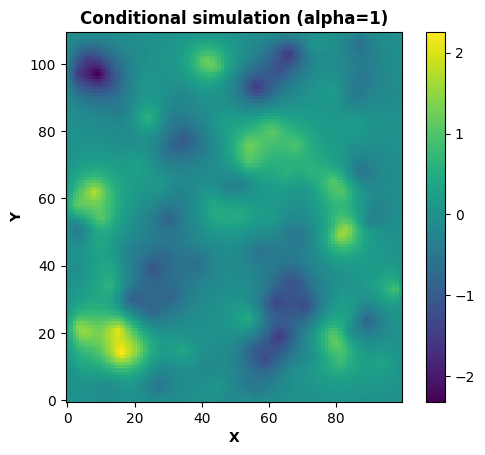

In [ ]:
plt.imshow(z_k_a1_cond.reshape(ny, nx), origin="lower")
plt.xlabel("X", fontweight="bold")
plt.ylabel("Y", fontweight="bold")
plt.title("Conditional simulation (alpha=1)", fontweight="bold")
plt.colorbar()

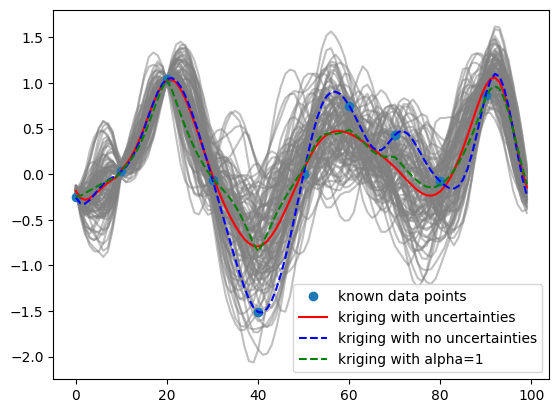

In [ ]:
plt.plot(simus[:, id_check_sel_all].T, color="grey", alpha=0.5)
plt.plot(np.arange(0, nx, step=10), z_k_a2[id_check_sel_dat], linestyle="none", marker="o", label="known data points")
plt.plot(z_k_a2_cond[id_check_sel_all], color="r", label="kriging with uncertainties")
plt.plot(z_k_a2[id_check_sel_all], color="b", label="kriging with no uncertainties", linestyle="--")
plt.plot(z_k_a1_cond[id_check_sel_all], color="g", label="kriging with alpha=1", linestyle="--")
plt.legend()

- Get the regularization with no data points to fit (only the variogram is encoded)

In [ ]:
get_reg_loglikelihood(Q_a2, z_k_a1_cond, prior)

1199.171877140002

- Get the regularization with the data points as a constraints

In [ ]:
get_reg_loglikelihood(Q_a2_cond, z_k_a1_cond, prior)

4049.813504896011

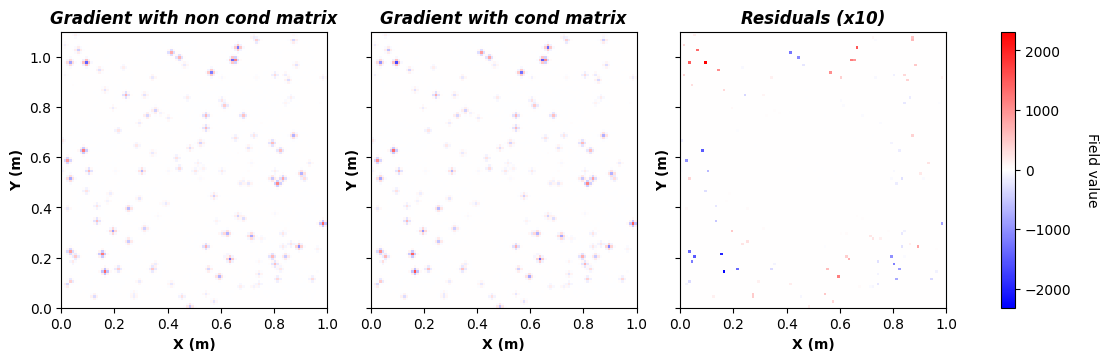

In [ ]:
plotter = NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (11, 3.5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

multi_imshow(
    axes=plotter.axes,
    fig=plotter.fig,
    data={
        "Gradient with non cond matrix": get_reg_loglikelihood_gradient(Q_a2, z_k_a1_cond, prior).reshape(ny, nx).T,
        "Gradient with cond matrix": get_reg_loglikelihood_gradient(Q_a2_cond, z_k_a1_cond, prior).reshape(ny, nx).T,    
        "Residuals (x10)": (get_reg_loglikelihood_gradient(Q_a2, z_k_a1_cond, prior) - get_reg_loglikelihood_gradient(Q_a2_cond, z_k_a1_cond, prior)).reshape(ny, nx).T * 10
        },
    cbar_title="Field value",
    imshow_kwargs={"cmap": plt.get_cmap("bwr"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X (m)",
    ylabel="Y (m)",
    is_symetric_cbar=True
)

In [ ]:
Q_a3

<11000x11000 sparse matrix of type '<class 'numpy.float64'>'
	with 897060 stored elements in Compressed Sparse Row format>